# Comparing Ground Truth with Gridded Products

## 1. The Weather Company

In [163]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, datetime, timedelta
import requests
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.plotting.register_matplotlib_converters()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from lib.wx_utilities import *

In [165]:
# Some attributes of this site
lat, long, start, end = (41.17932065372352, -96.44152082846212, '2018-05-09', '2018-10-15')

In [166]:
# Read Device Data
df = pd.read_csv('dat/UNLCSP-3_daily.csv')
df['UTC'] = pd.to_datetime(df['UTC'], utc=True)

In [168]:
# Make a Backbone
df2 = pd.DataFrame()
df2['date'] = pd.date_range(start=start, end=end, freq="D", tz="UTC")

In [169]:
# Fetch TWC Gridded
wdf = pd.read_csv('dat/UNLCSP-3_twc.csv')
wdf = rename_wx_daily_for_merge(wdf)
wdf['date'] = pd.to_datetime(wdf['date'], utc=True)

In [170]:
# Merge everything
df2 = df2.merge(df, left_index=False, right_index=False, left_on='date',right_on='UTC', how='left')
df2 = df2.merge(wdf, left_on='date', right_on='date', how='left')

In [173]:
df2

,date,tenant,site_id,UTC,device,Tmean,Tmin,Tmax,Precip_1d,SWdw_sum,...,RH_min_twc,RH_max_twc,P_twc,SLP_twc,U_twc,Udir_twc,Precip_1d_twc,Snow_1d,SWdw_sum_twc,ETo_sum_twc
0,2018-05-09 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-05-09 00:00:00+00:00,A000653,NaN,NaN,NaN,0.855823,NaN,...,0.38,0.81,96.46,100.85,4.4,304,0.00000,0.0,7768,5.688
1,2018-05-10 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-05-10 00:00:00+00:00,A000653,19.55130,11.800400,26.60110,0.551158,27.94720,...,0.42,0.83,96.74,101.14,3.1,139,0.00000,0.0,7602,5.448
2,2018-05-11 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-05-11 00:00:00+00:00,A000653,14.75750,8.726610,19.48830,7.674270,12.97740,...,0.53,0.87,96.36,100.77,4.8,60,0.00254,0.0,7652,5.184
3,2018-05-12 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-05-12 00:00:00+00:00,A000653,12.16880,9.956080,14.20760,1.124920,6.97329,...,0.61,0.88,96.72,101.19,4.6,34,0.04300,0.0,3731,3.720
4,2018-05-13 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-05-13 00:00:00+00:00,A000653,15.38680,11.576700,23.73440,0.002019,18.48020,...,0.58,0.94,96.91,101.37,2.4,43,0.05500,0.0,4901,4.512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2018-10-11 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-10-11 00:00:00+00:00,A000653,5.60649,3.060660,15.12980,NaN,12.14480,...,0.52,0.80,97.43,102.09,4.3,308,0.01600,0.1,4768,2.088
157,2018-10-12 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-10-12 00:00:00+00:00,A000653,5.72364,1.765050,13.31460,NaN,3.03107,...,0.66,1.00,97.22,101.86,1.4,194,0.86200,0.0,1269,0.816
158,2018-10-13 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-10-13 00:00:00+00:00,A000653,8.49645,0.732511,18.36420,NaN,17.02170,...,0.62,0.99,96.70,101.25,3.8,209,0.00000,0.0,4497,2.136
159,2018-10-14 00:00:00+00:00,franz-hydro,UNLCSP-3,2018-10-14 00:00:00+00:00,A000653,2.60655,-0.047098,9.80053,NaN,3.24226,...,0.84,0.96,97.15,101.79,5.4,217,0.97800,6.1,1021,0.864


# Compare Different Data Sources

Text(0, 0.5, 'Temp Difference')

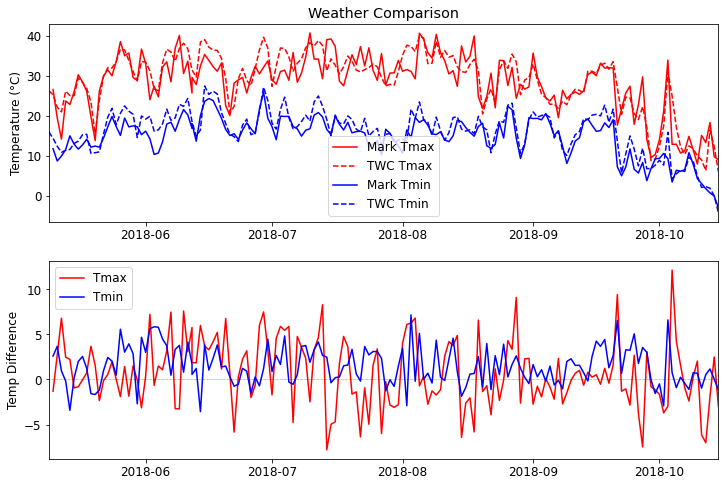

In [175]:
# Temperature Compare
xlim = [pd.to_datetime(start), pd.to_datetime(end)]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# Date versus Temp
line1 = axes[0].plot(df2.date, df2.Tmax, c='r', label = 'Mark Tmax')
line1 = axes[0].plot(df2.date, df2.Tmax_twc, c='r', ls='--', label = 'TWC Tmax')

line1 = axes[0].plot(df2.date, df2.Tmin, c='b', label = 'Mark Tmin')
line1 = axes[0].plot(df2.date, df2.Tmin_twc, c='b', ls='--', label = 'TWC Tmin')

ylim = axes[0].get_ylim()    

axes[0].set_xlim(xlim)    
axes[0].set_ylim(ylim)    
axes[0].legend()
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Weather Comparison')

# Date versus Temp Difference
line1 = axes[1].plot(df2.date, df2.Tmax_twc-df2.Tmax, c='r', label = 'Tmax')
line1 = axes[1].plot(df2.date, df2.Tmin_twc-df2.Tmin, c='b', label = 'Tmin')
line1, = axes[1].plot(xlim, [0, 0], c='b', lw=0.5, ls=':')

ylim = axes[1].get_ylim()    

axes[1].set_xlim(xlim)    
axes[1].set_ylim(ylim)    
axes[1].legend()
axes[1].set_ylabel('Temp Difference')

Text(0, 0.5, 'Precip (mm)')

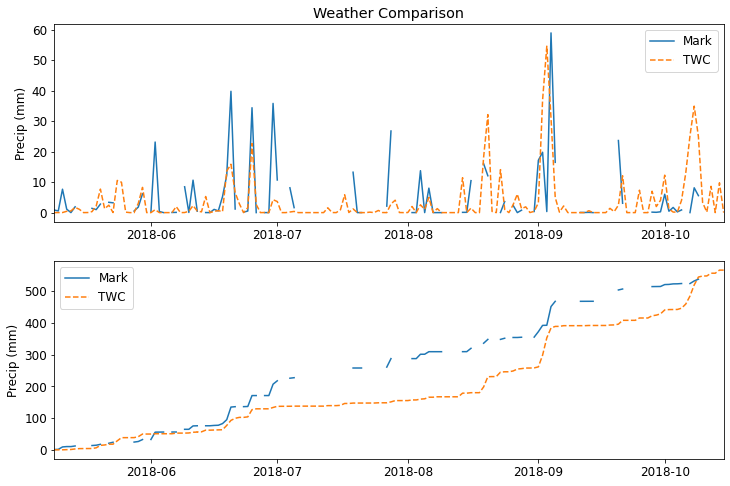

In [10]:
# Precip Compare
xlim = [pd.to_datetime(start), pd.to_datetime(end)]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

# Date versus Rain
line1 = axes[0].plot(df2.date, df2.Precip_1d, c='C0', label = 'Mark')
line1 = axes[0].plot(df2.date, df2.Precip_1d_twc*10, c='C1', ls='--', label = 'TWC')

ylim = axes[0].get_ylim()    

axes[0].set_xlim(xlim)    
axes[0].set_ylim(ylim)    
axes[0].legend()
axes[0].set_ylabel('Precip (mm)')
axes[0].set_title('Weather Comparison')

# Cumulative Rain
line1 = axes[1].plot(df2.date, np.cumsum(df2.Precip_1d), c='C0', label = 'Mark')
line1 = axes[1].plot(df2.date, np.cumsum(df2.Precip_1d_twc*10), c='C1', ls='--', label = 'TWC')

ylim = axes[1].get_ylim()    

axes[1].set_xlim(xlim)    
axes[1].set_ylim(ylim)    
axes[1].legend()
axes[1].set_ylabel('Precip (mm)')

# Exercises

1. What is the mean difference and root mean square error of the daily temperature max and min?

In [178]:
def error_metrics(vector1, vector2):
    mu = np.mean(vector1 - vector2)
    mae = np.mean(np.abs(vector1 - vector2))
    rmse = np.sqrt(((vector1 - vector2) ** 2).mean())
    return([mu, mae, rmse])

[error_metrics(df2.Tmax_twc, df2.Tmax), 
 error_metrics(df2.Tmin_twc, df2.Tmin)]

# np.mean(df2.Tmax_twc - df2.Tmax)

[[0.7248482500000002, 3.0056661250000003, 3.7882569452604127],
 [1.5008370449999997, 2.0212675449999997, 2.5927645784024675]]

2. If harvest time was 1750 degree days, how many days different would that be between TWC and Mark?

    This code may come in useful:
    ```python
from lib.biology import *
# The column names can be changed to use the TWC temperatures instead
df2['GDD'] = GDD(df2, Tlo=10., Thi=44., method='II', Tmincol='Tmin', Tmaxcol='Tmax') 
df2['GDD'] = np.cumsum(df2['GDD'])
    ```

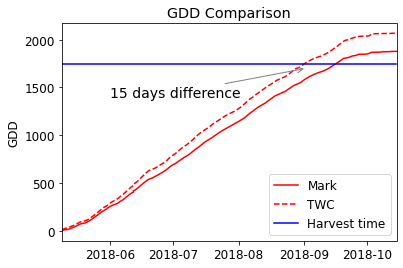

In [183]:
from lib.biology import *
df2['GDD'] = GDD(df2, Tlo=10., Thi=44., method='II', Tmincol='Tmin', Tmaxcol='Tmax') 
df2['GDD'] = np.cumsum(df2['GDD'])
df2['GDD_twc'] = GDD(df2, Tlo=10., Thi=44., method='II', Tmincol='Tmin_twc', Tmaxcol='Tmax_twc') 
df2['GDD_twc'] = np.cumsum(df2['GDD_twc'])
# df2[['GDD_twc', 'GDD']]


twc_harvest_ind = np.where(df2['GDD_twc'] > 1750)[0][0]
# np.where(df2['GDD_twc'] > 1750)[0][0]
mark_harvest_ind = np.where(df2['GDD'] > 1750)[0][0]
harvest_diff = df2['date'].iloc[twc_harvest_ind] - df2['date'].iloc[mark_harvest_ind]

# ### Plot
# # GDD Compare
xlim = [pd.to_datetime(start), pd.to_datetime(end)]
textx = pd.to_datetime("2018-06-01")

plt.plot(figsize=(8,8))

# Date versus Temp
plt.plot(df2.date, df2.GDD, c = 'r', label = 'Mark GDD')
plt.plot(df2.date, df2.GDD_twc, c = 'r', ls='--', label = 'TWC GDD')
plt.plot(xlim, (1750, 1750), c = "b", label = "Harvest time")
plt.annotate("%s days difference" % np.abs(harvest_diff.days), 
             xy = (df2['date'].iloc[twc_harvest_ind], 1700), 
             xytext = (textx, 1400), 
             fontsize = 14, arrowprops = dict(arrowstyle = "->", color = 'grey'))

ylim = plt.gca().get_ylim() #axes.get_ylim()    
plt.gca().set_xlim(xlim)    
plt.gca().set_ylim(ylim)
plt.legend()
plt.gca().set_ylabel('GDD')
plt.gca().set_title('GDD Comparison')

plt.show()

3. Open the file dat/CSP-3_2018.csv. What are the GDD thresholds for the different growth stages?

    This code may be useful:
    
    ```python
    obs = pd.read_csv('dat/CSP-3_2018.csv')
    obs['date'] = pd.to_datetime('2018-01-01') + obs['doy'].map(timedelta)
    ```


Read in pandas, create date object for each growthstage observation, convert units to allow merge with `df2`

In [186]:
obs = pd.read_csv('dat/CSP-3_2018.csv')
obs['date'] = pd.to_datetime('2018-01-01') + obs['doy'].map(timedelta)
obs['date'] = pd.to_datetime(obs['date'], utc=True, unit = 'D')

,Year,doy,GrowthStage,Height\r(cm),GreenLAI,DeadLAI,LAI,DryAGBiomass (kg/ha),GreenFraction,DeadFraction,StemFraction,GrainFraction,GreenLeafBiomass,DeadLeafBiomass,StemBiomass,GrainBiomass,WetAGBiomass (kg/ha),date
0,2018,141,NaN,0.0,0.000,0.000,0.000,0,0.00%,0.00%,0.00%,0.00%,0,0,0,0,0,2018-05-22 00:00:00+00:00
1,2018,158,V1,13.7,0.183,0.000,0.183,111,64.50%,0.00%,35.50%,0.00%,72,0,39,0,674,2018-06-08 00:00:00+00:00
2,2018,169,V2,33.5,0.751,0.000,0.751,431,61.20%,0.00%,38.80%,0.00%,264,0,167,0,"2,459",2018-06-19 00:00:00+00:00
3,2018,173,V4,44.3,1.030,0.000,1.030,636,54.40%,0.00%,45.60%,0.00%,346,0,290,0,"3,664",2018-06-23 00:00:00+00:00
4,2018,180,R1,59.0,1.930,0.000,1.930,965,45.60%,0.00%,54.40%,0.00%,440,0,525,0,"6,875",2018-06-30 00:00:00+00:00
5,2018,187,R2,69.3,2.033,0.000,2.033,1554,44.60%,0.00%,55.40%,0.00%,693,0,861,0,"8,983",2018-07-07 00:00:00+00:00
6,2018,197,R3,85.8,3.804,0.035,3.839,3087,41.20%,0.50%,58.30%,0.00%,"1,272",16,"1,800",0,"16,651",2018-07-17 00:00:00+00:00
7,2018,204,R4,100.5,3.861,0.078,3.939,3930,37.60%,0.80%,59.90%,1.70%,"1,477",33,"2,354",65,"20,363",2018-07-24 00:00:00+00:00
8,2018,214,R5,114.2,4.211,0.183,4.394,5830,30.90%,1.30%,56.50%,11.20%,"1,801",78,"3,296",655,"27,233",2018-08-03 00:00:00+00:00
9,2018,228,R6,116.0,4.059,0.112,4.170,7799,21.90%,0.70%,49.20%,28.20%,"1,710",54,"3,834","2,201","35,203",2018-08-17 00:00:00+00:00


Conduct merge on limited number of columns

In [189]:
vars = ['date', 'GDD', 'GDD_twc']
df_gstages = df2[vars].merge(obs[['date', 'GrowthStage']], left_index=False, right_index=False, 
                             left_on='date',right_on='date', how='inner')

In [190]:
df_gstages

,date,GDD,GDD_twc,GrowthStage
0,2018-05-22 00:00:00+00:00,104.040585,125.40,NaN
1,2018-06-08 00:00:00+00:00,341.282235,397.70,V1
2,2018-06-19 00:00:00+00:00,535.738985,622.90,V2
3,2018-06-23 00:00:00+00:00,576.364835,664.70,V4
4,2018-06-30 00:00:00+00:00,680.412785,781.45,R1
5,2018-07-07 00:00:00+00:00,779.397535,895.35,R2
6,2018-07-17 00:00:00+00:00,943.098185,1072.05,R3
7,2018-07-24 00:00:00+00:00,1045.582385,1177.75,R4
8,2018-08-03 00:00:00+00:00,1170.879135,1314.10,R5
9,2018-08-17 00:00:00+00:00,1390.617585,1543.45,R6
